## Multi-label Classification (Planet Dataset)

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
# import convolution tools
from fastai.conv_learner import *
# import pandas for csv visualization
import pandas as pd

In [12]:
# set our path to the planet data set
PATH = 'data/planet/'

In [13]:
# list our sub directories
!ls {PATH}

models	test-jpg  tmp  train-jpg  train_v2.csv


In [14]:
df = pd.read_csv("data/planet/train_v2.csv")
print(df.head())

  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


In [15]:
# plotting library from fastai
from fastai.plots import *

In [16]:
# gets the first picture in a path
def get_1st(path): 
    # glob lets you return potentially empty file locs without throwing an error
    # this just says give me the first of anything.anything in PATH
    return glob(f'{path}/*.*')[0]

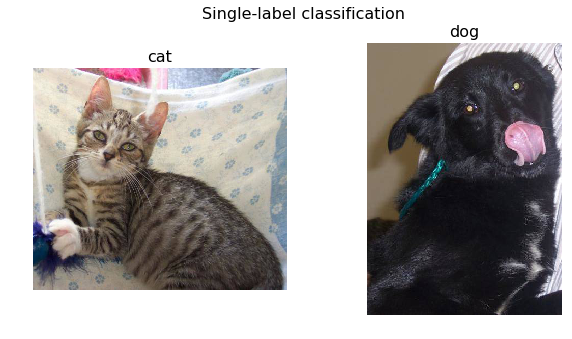

In [17]:
# go to the valid dogs and cats this is to showcase the difference between single and multilabel 
# classification
dc_path = "data/dogscats/valid/"

# creates a list of things we will later plot
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]

# plots the list above with sub and main titles
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

Remember to use A sigmoid instead of Softmax for multilabel classification

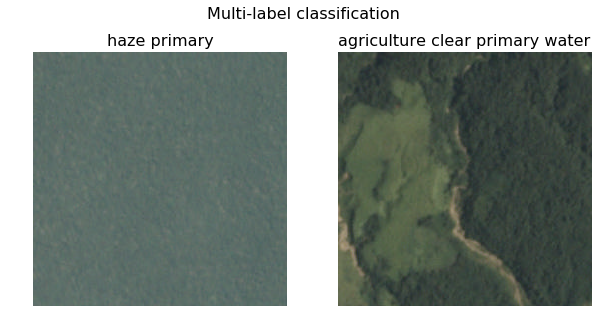

In [18]:
# this does the same as above
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]

titles=["haze primary", "agriculture clear primary water"]

plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [19]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

# this a predifined metric by Jeremy for checking error using beta score
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [20]:
# f2 is like a confusion matrix
# there are lots of different ways you can turn that confusion matrix into a score
# f2 is f beta with beta=2, the kaggle competition wanted this
# 
metrics=[f2]
f_model = resnet34

In [21]:
# The csv file containing our labels
label_csv = f'{PATH}train_v2.csv'

#o = open(label_csv)
#li = list(o)
#n = len(li)-1

n = len(list(open(label_csv)))-1

val_idxs = get_cv_idxs(n)

In [22]:
# takes in the size of the image and returns a ImageClassifierData object
def get_data(sz):
    # apply transforms
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [23]:
# the images are 256 x 256
data = get_data(256)

In [24]:
# ds is data set
# this will give you a single image back

# dl is data loader
# a data loader gives you back a minibatch
# specifically a transformed minibatch
# also you can only get the next minibatch so a good practice 
# would be to loop through and grab a minibatch at a time

# for more info google pytorch data set and data loader


x,y = next(iter(data.val_dl))

In [25]:
# batch size by default is 64 in the function
# so its 64 by 17 possible classes or labels
# this also seems to be transposed so its index x class
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [26]:
# zip will combine lists 
# so you will get the 0th thing from the first list and the 0th thing from the second list
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

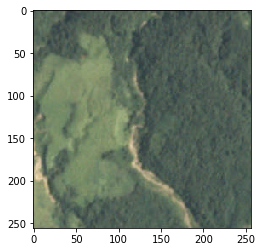

In [27]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [28]:
# we do this here since there is nothing like satellite images in the imagenet model
# we wouldn't do this with the cats and dogs because we would destroy the weights
sz=64

In [29]:
# create data object
data = get_data(sz)

In [30]:
# this speeds things up by saying 
# I won't be needing anything bigger than sz*1.3

data = data.resize(int(sz*1.3), 'tmp')

In [31]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.223709   0.269339   0.825095  



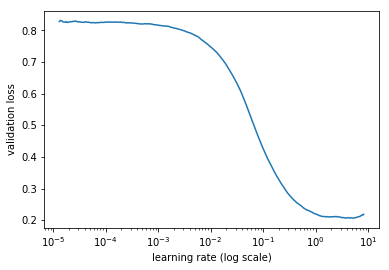

In [32]:
lrf=learn.lr_find()
learn.sched.plot()

In [33]:
lr = 0.2

In [34]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.147102   0.133033   0.883338  
    1      0.141103   0.127185   0.889755                    
    2      0.139051   0.125667   0.892151                    
    3      0.137805   0.124761   0.892294                    
    4      0.136067   0.122831   0.89526                     
    5      0.132859   0.121276   0.896396                    
    6      0.131545   0.121369   0.895219                    



[array([0.12137]), 0.8952189648278935]

In [35]:
# notice the learning rate is greater for all 3 layers compared to the cats and dogs
# this is because imagenet was more suited for the cats and dogs model
# satellite data is much different so we set a higher learning rate 
# at lower layers, but still less than our top layers

# Also notice how we don't do this right away
# this is because our layers would be random
# we should train our layers first then unfreeze the imagenet layers 
# for retraining
lrs = np.array([lr/9,lr/3,lr])

In [36]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.120365   0.109936   0.907705  
    1      0.116826   0.107446   0.907156                    
    2      0.107001   0.101385   0.915106                    
    3      0.112509   0.102195   0.913443                    
    4      0.105939   0.101563   0.915094                    
    5      0.102347   0.097551   0.917749                     
    6      0.097418   0.097372   0.918057                     



[array([0.09737]), 0.9180571787743648]

In [37]:
learn.save(f'{sz}')

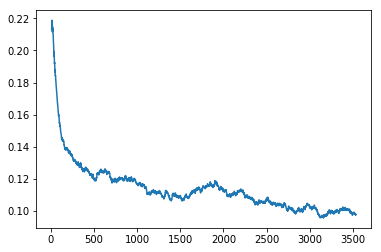

In [38]:
learn.sched.plot_loss()

In [39]:
sz=128

In [40]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.09867    0.094844   0.91859   
    1      0.097065   0.093558   0.920441                     
    2      0.095911   0.092839   0.920789                     
    3      0.09785    0.092624   0.921624                     
    4      0.098201   0.092687   0.920607                     
    5      0.09571    0.091823   0.92184                      
    6      0.094101   0.09177    0.921351                     



[array([0.09177]), 0.9213513015617453]

In [41]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.094061   0.087197   0.926153  
    1      0.092818   0.086996   0.928174                     
    2      0.091056   0.084689   0.929947                     
    3      0.091446   0.089575   0.92483                      
    4      0.087511   0.085343   0.929945                     
    5      0.085561   0.08384    0.930323                     
    6      0.083966   0.083565   0.930993                     



In [47]:
sz=256

In [43]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.093788   0.088406   0.925103  
    1      0.092152   0.087738   0.926359                     
    2      0.089541   0.086787   0.927078                     
    3      0.090457   0.087079   0.925858                     
    4      0.088064   0.086749   0.926517                     
    5      0.091159   0.085939   0.927563                     
    6      0.08619    0.085856   0.92778                      



[array([0.08586]), 0.9277797506975684]

In [44]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.087228   0.082125   0.931622  
    1      0.090669   0.083097   0.929711                     
    2      0.083937   0.08099    0.932874                     
    3      0.087432   0.083413   0.930149                     
    4      0.083918   0.082244   0.932266                     
    5      0.079948   0.08139    0.932267                     
    6      0.077498   0.080706   0.933599                     



In [45]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [46]:
f2(preds,y)

0.9316254029148617